In [1]:
include("IsingModel.jl")
using .IsingModel
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, ProgressMeter
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(IsingModel))

[:IsingModel, :calc_energy, :calc_gradient, :calc_gradient_no_constraints, :calc_magnetization, :calc_round_trip_times, :initial_state, :metropolis_sampler]


In [2]:
N = 20
β_min = 0.1
β_max = 1.0
M = 20
η = 0.005
eqSteps = 10^2
mcSteps = 10^4
epochs = 300
batch_size = 10

@info """
Hyperparameters of Ising model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
init_β_set = Utils.set_temperatures(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
init_logΔβ = β2logD(init_β_set)
_, exchange_prob_means = IsingModel.calc_gradient(N, init_β_set; eqSteps, mcSteps)

println(init_β_set)
println(init_logΔβ)
println(logD2β(init_logΔβ[1:M-2], β_min, β_max))
println(exchange_prob_means)

[0.1, 0.11288378916846893, 0.12742749857031338, 0.1438449888287663, 0.16237767391887217, 0.1832980710832436, 0.20691380811147897, 0.23357214690901226, 0.26366508987303583, 0.29763514416313186, 0.3359818286283782, 0.379269019073225, 0.4281332398719394, 0.4832930238571753, 0.5455594781168519, 0.6158482110660264, 0.6951927961775606, 0.7847599703514613, 0.8858667904100826, 1.0]
[-4.351785411472832, -4.230596722367886, -4.109408033262932, -3.9882193441579865, -3.8670306550530333, -3.7458419659480855, -3.624653276843134, -3.5034645877381863, -3.3822758986332344, -3.2610872095282866, -3.1398985204233347, -3.018709831318387, -2.897521142213437, -2.7763324531084868, -2.6551437640035367, -2.5339550748985875, -2.412766385793637, -2.2915776966886874, -2.1703890075837378]
[0.1, 0.11288378916846893, 0.12742749857031338, 0.1438449888287663, 0.16237767391887217, 0.1832980710832436, 0.20691380811147897, 0.23357214690901226, 0.26366508987303583, 0.29763514416313186, 0.3359818286283782, 0.379269019073225

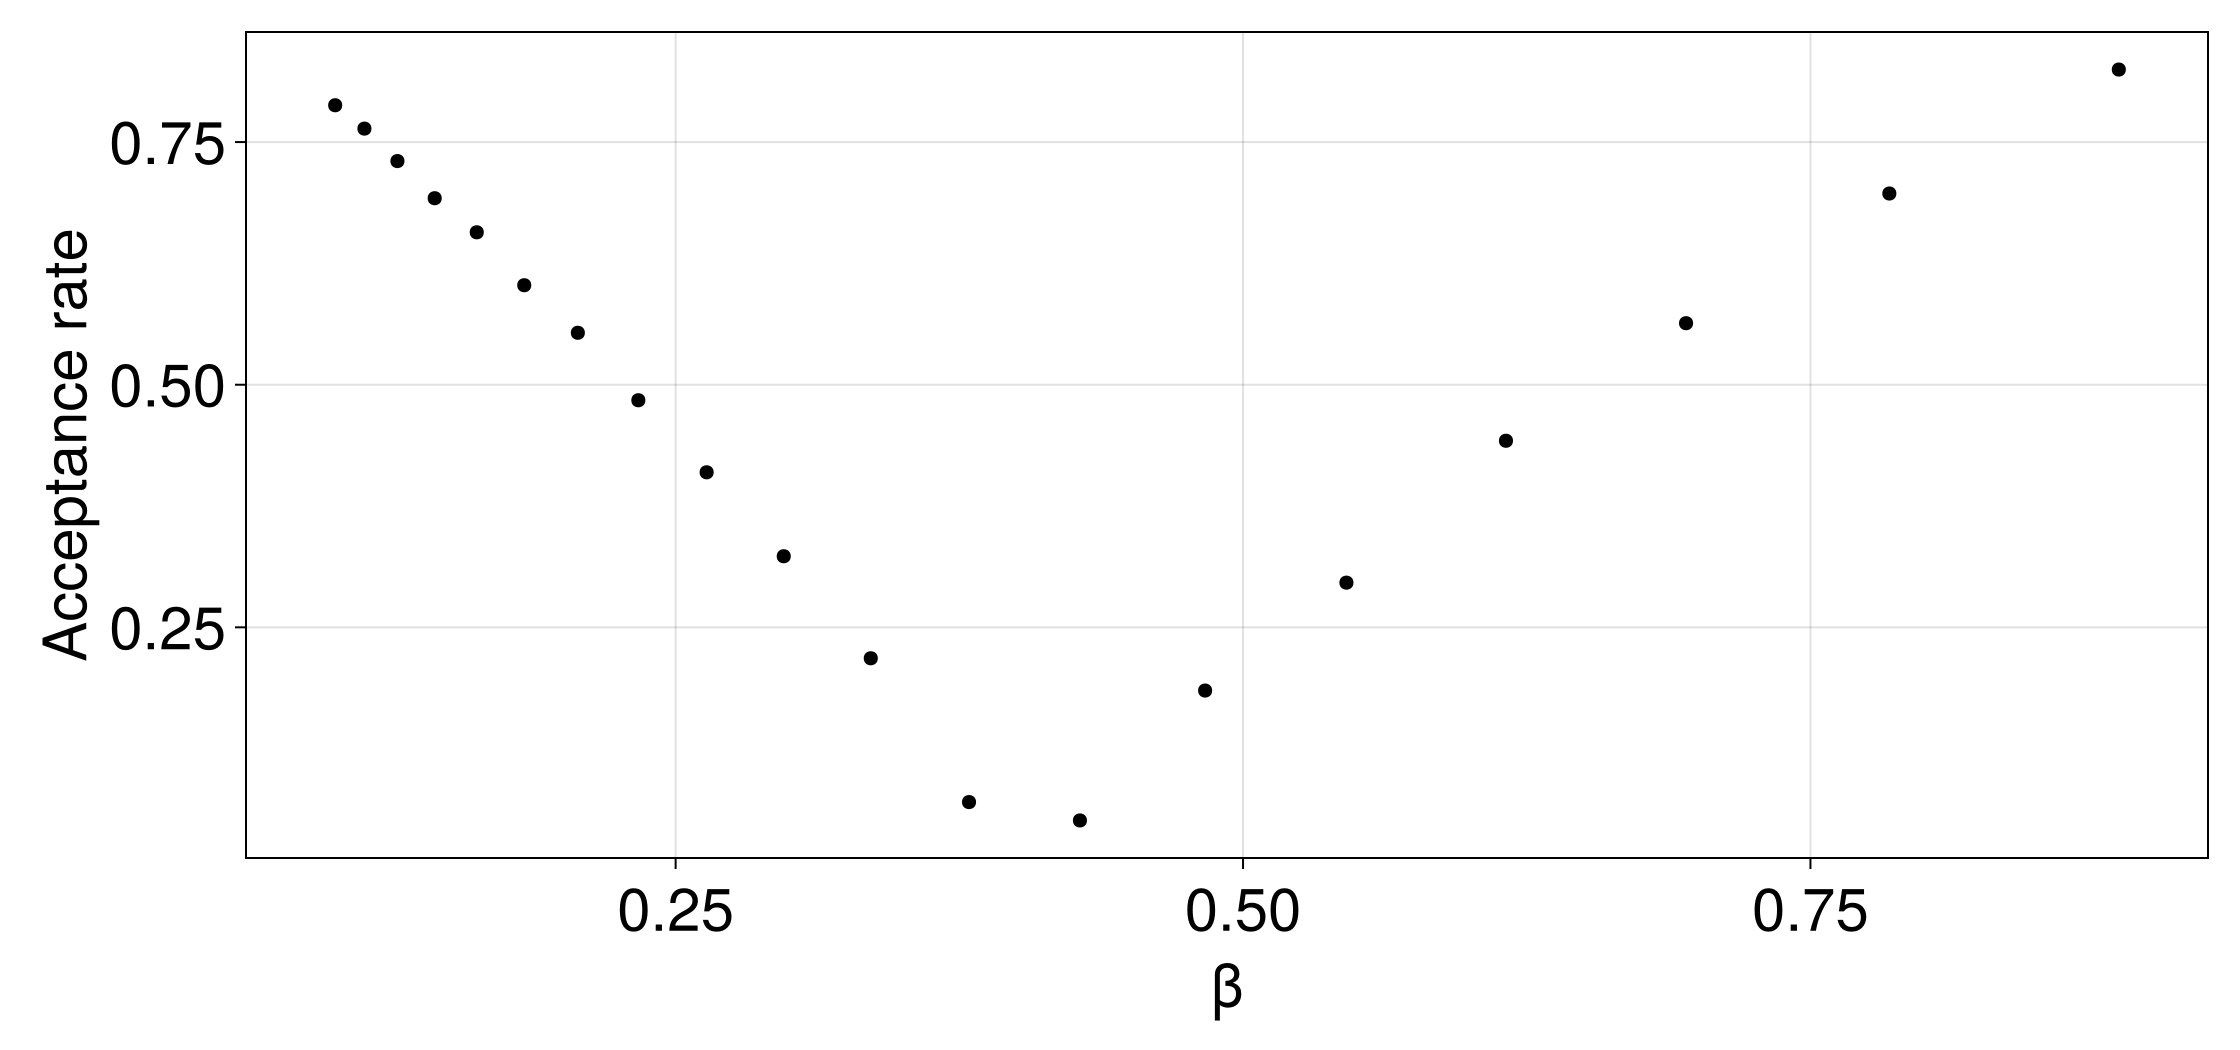

CairoMakie.Screen{IMAGE}


In [4]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
scatter!(ax1, init_β_set[1:(end-1)], exchange_prob_means, color=:black, markersize=10)

display(fig1)

In [5]:
β_set = deepcopy(init_β_set)
β_set_trace = [β_set]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β2logD(β_set)[1:M-2])

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = IsingModel.calc_gradient(
            N, 
            β_set;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)

    logΔβ = β2logD(β_set)[1:M-2]
    setup, logΔβ = Optimisers.update(setup, logΔβ, grad_mean)
    β_set = logD2β(logΔβ, β_min, β_max)

    push!(β_set_trace, deepcopy(β_set))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5))±$(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 2:15:27


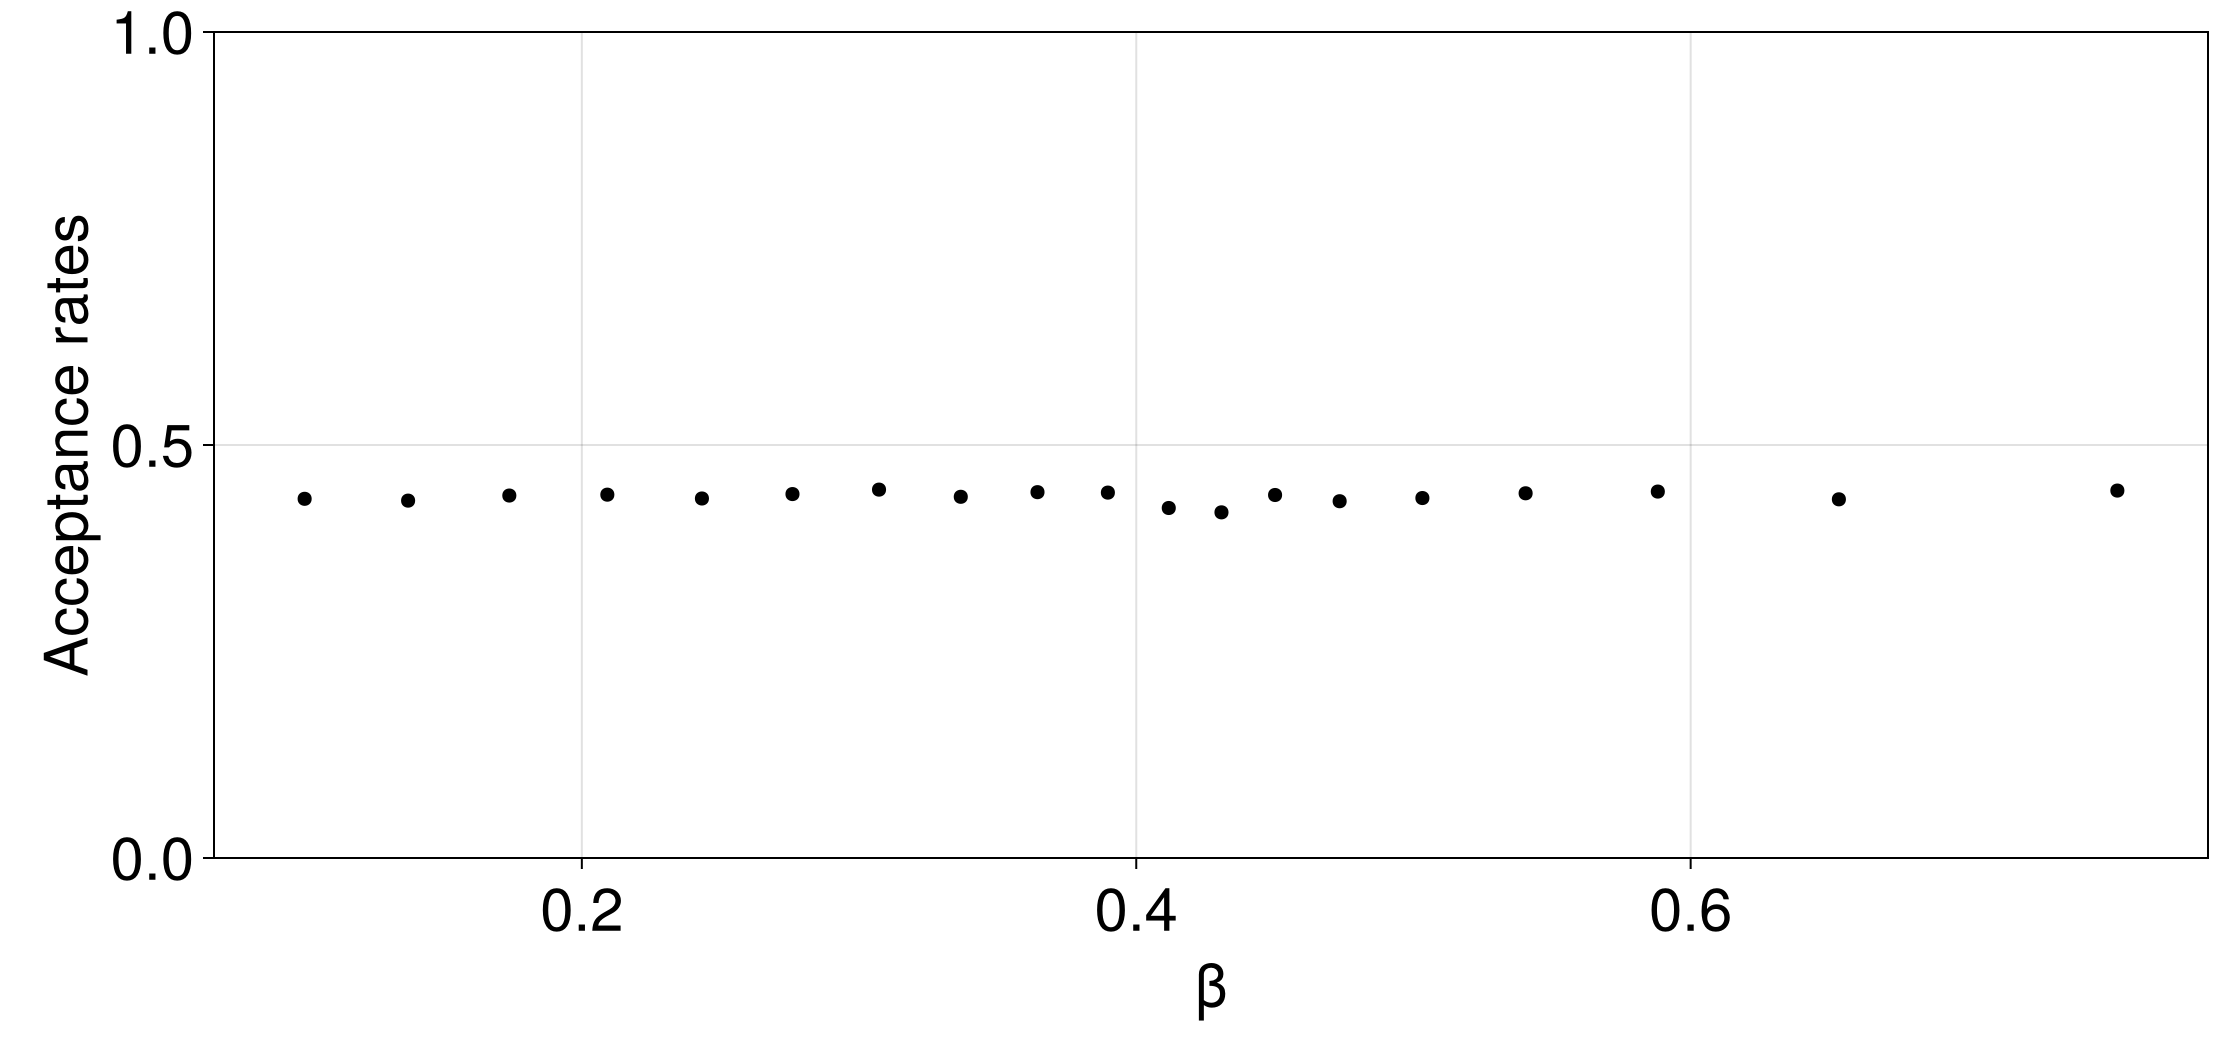

CairoMakie.Screen{IMAGE}


In [6]:
fig1 = Figure(size=(1120, 525), fontsize=30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rates")
ylims!(ax1, 0, 1)
scatter!(ax1, β_set_trace[end][1:(end-1)], exchange_prob_trace[end], color=:black, markersize=10)

display(fig1)

In [7]:
dir = "../../plots/Ising_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/Ising_model/L=20/M=20"

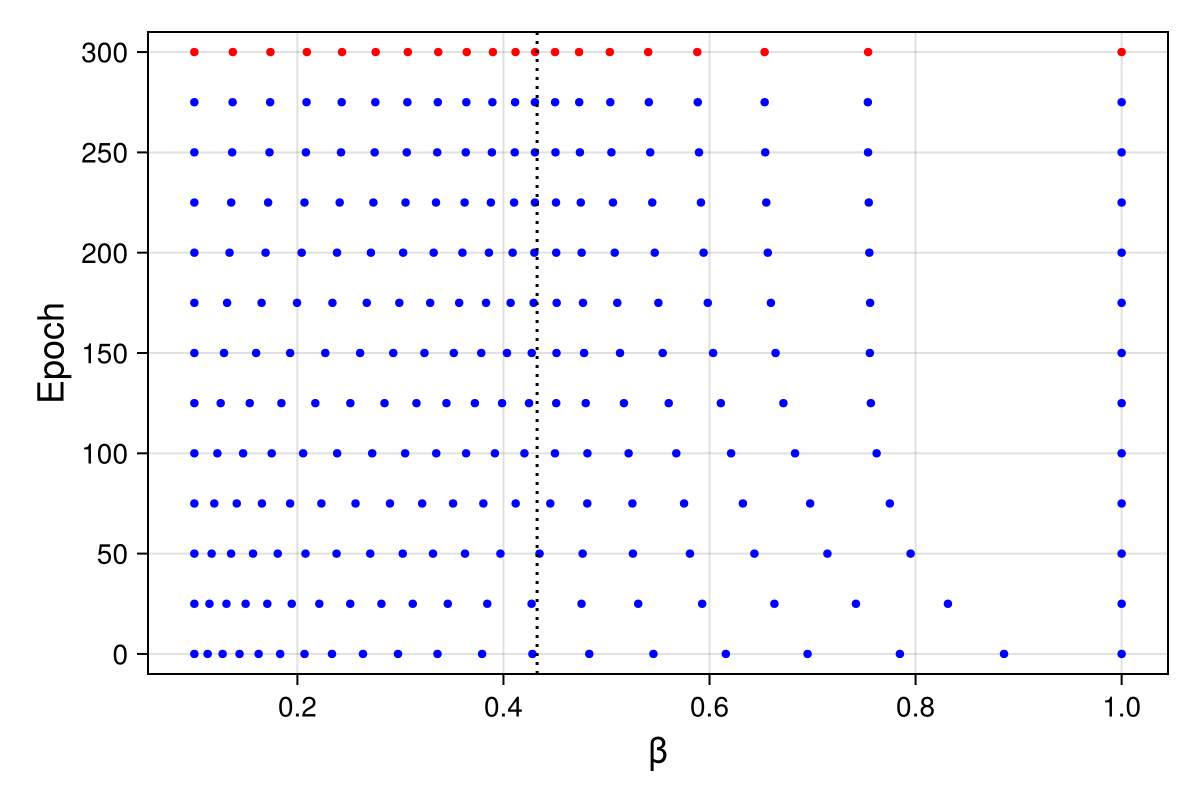

In [8]:
fig = Figure(font="Computer Modern", size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "Epoch",
    xlabelsize = 18,
    ylabelsize = 18,
    yticks = 0:50:epochs
)
# xlims!(ax, -0.05, 1.15)
ylims!(ax, -10, epochs + 10)

plot_interval = 25
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_set
        y_values = fill(step, length(β_values))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
# critical inverse temperature
# β_c = log(1 + sqrt(2)) / 2
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
# text!(
#     ax,
#     L"\beta_c \approx %$(round(β_c, digits=3))", 
#     position = (β_c, -15), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )

β_dash = 0.43266
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")

display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

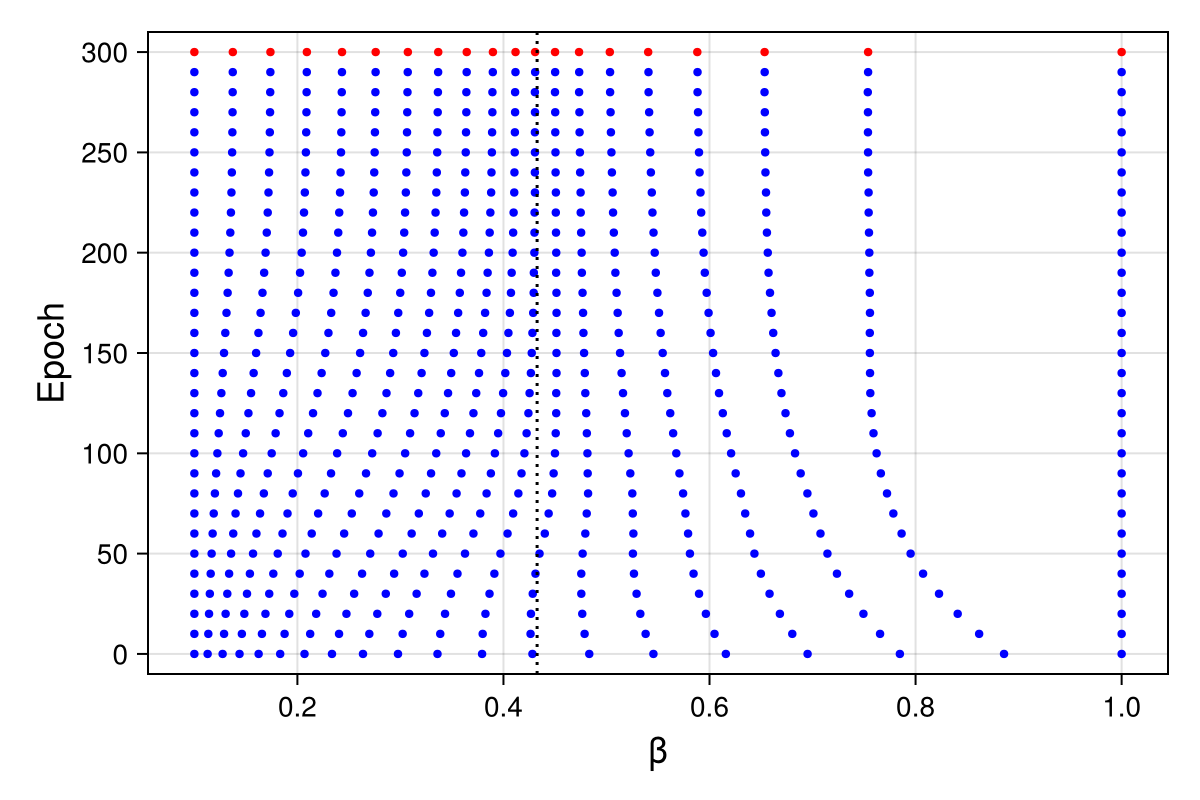

In [9]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "Epoch", 
    xlabelsize = 18,
    ylabelsize = 18, 
    yticks = 0:50:epochs
)
# xlims!(ax, -0.05, 1.15)
ylims!(ax, -10, epochs+10)

plot_interval = 10
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_set
        y_values = fill(step, length(β_values))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
# critical inverse temperature
# β_c = log(1 + sqrt(2)) / 2
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
# text!(
#     ax,
#     L"\beta_c \approx %$(round(β_c, digits=3))", 
#     position = (β_c, -15), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )

β_dash = 0.43266
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")

display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs every 10.png", fig; px_per_unit=4)

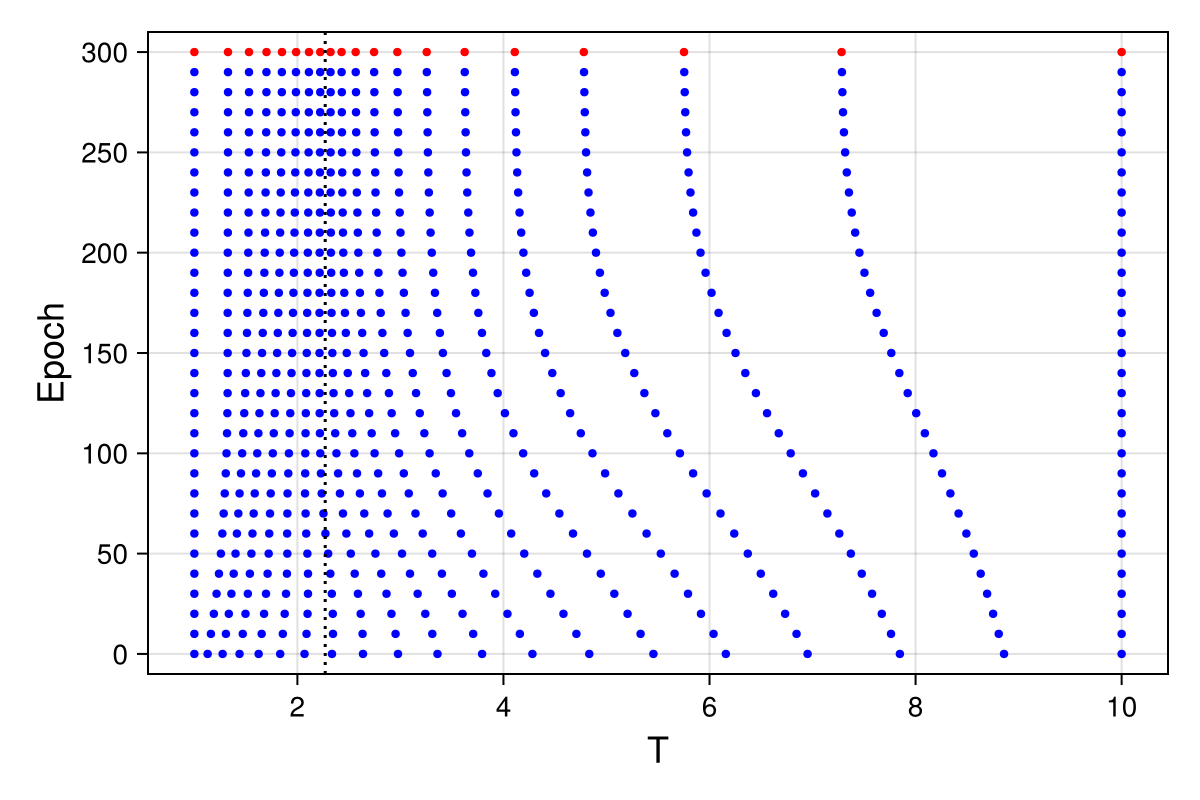

CairoMakie.Screen{IMAGE}


In [10]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "T",
    ylabel = "Epoch", 
    xlabelsize = 18,
    ylabelsize = 18, 
    yticks = 0:50:epochs
)
# xlims!(ax, -0.05, 1.15)
ylims!(ax, -10, epochs+10)

plot_interval = 10
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        T_values = 1 ./ β_set
        y_values = fill(step, length(T_values))
        marker_color = (step == 300) ? :red : :blue

        scatter!(ax, T_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end
T_c = 2.27
vlines!(ax, [T_c], color=:black, linestyle=:dot, label="Critical Tc")
# text!(
#     ax,
#     L"T_c \approx %$(round(T_c, digits=3))", 
#     position = (T_c, -15), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )

display(fig)
# save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

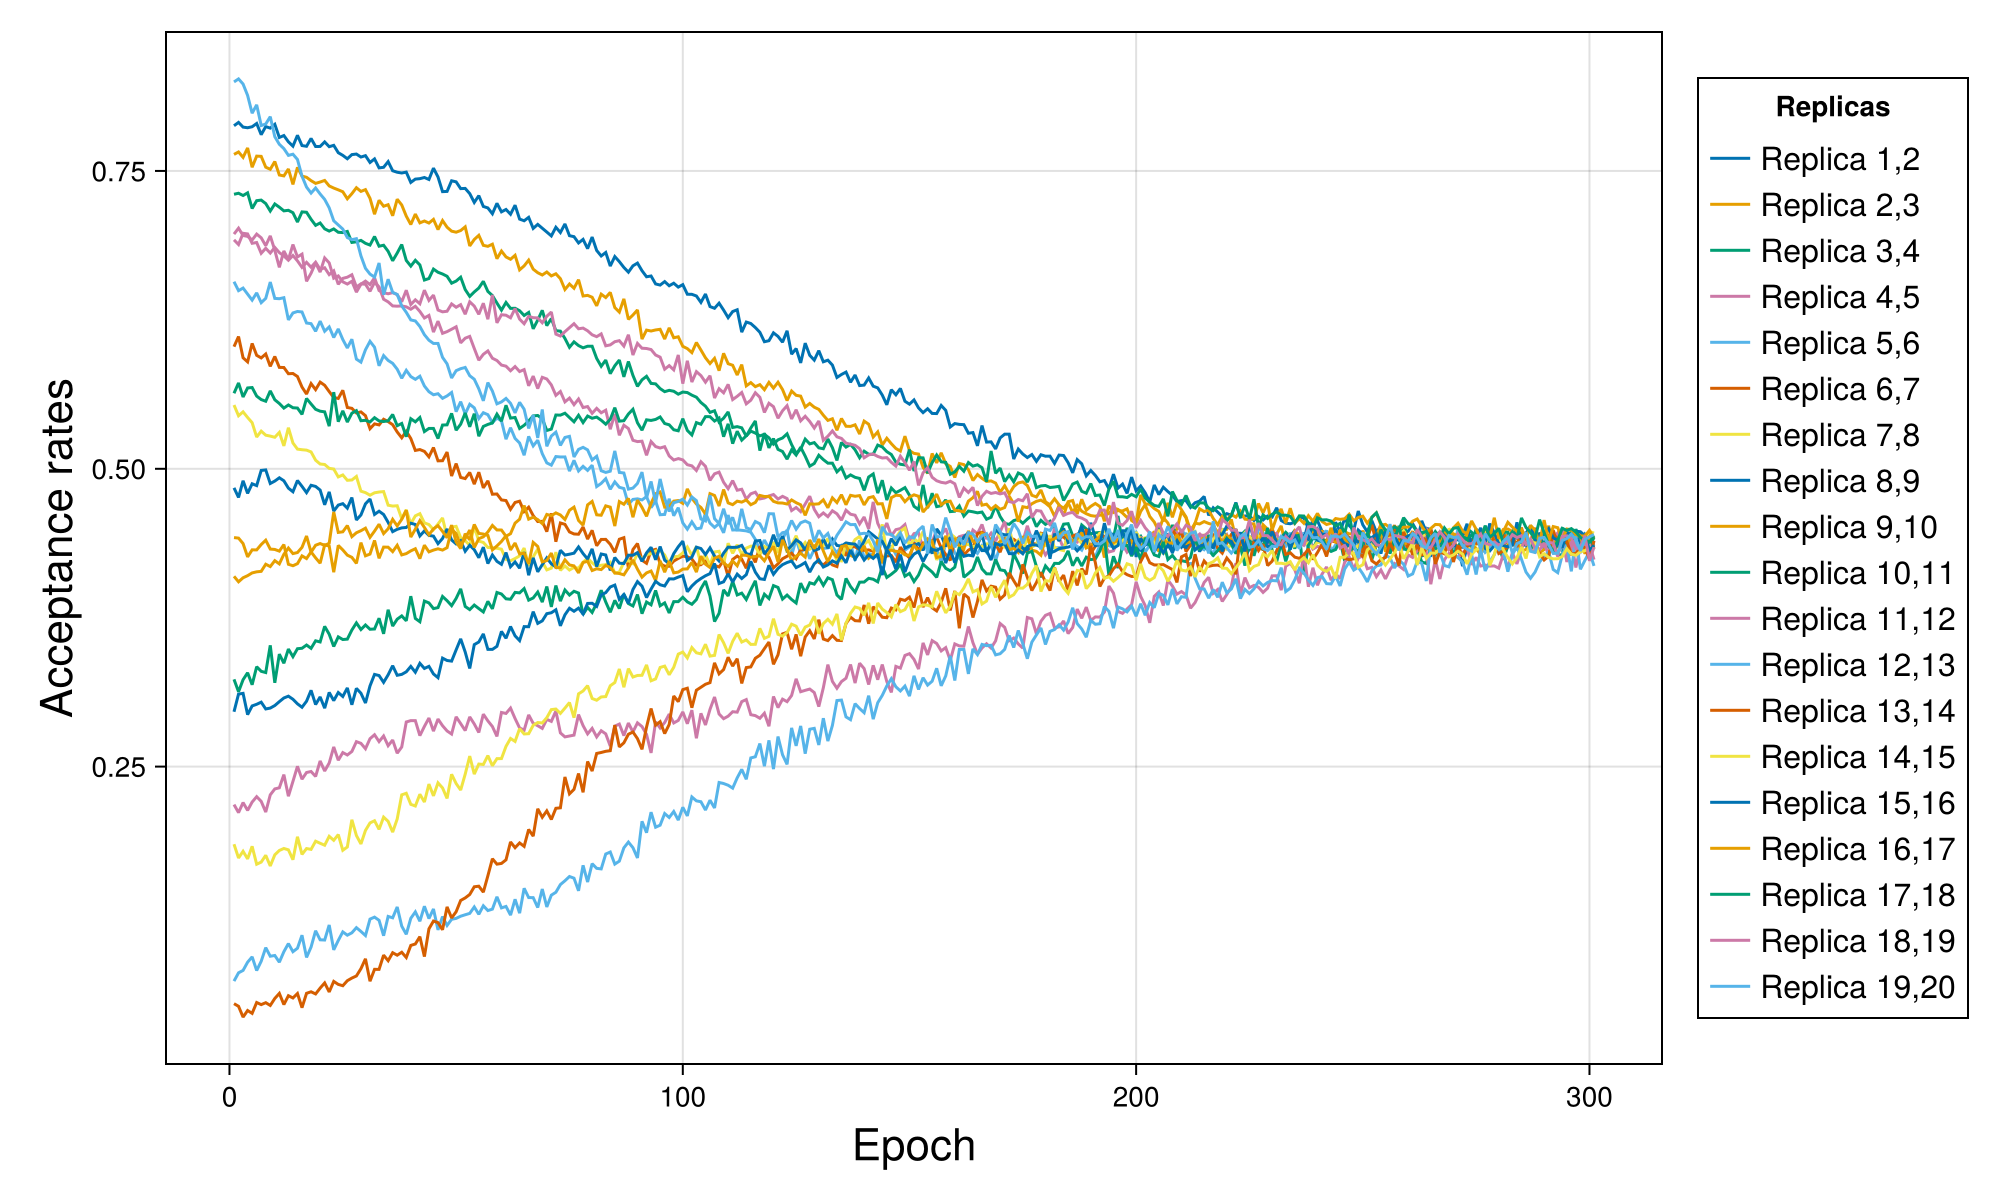

In [11]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size = (1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates",
    xlabelsize = 22,
    ylabelsize = 22
)
# xlims!(ax2, -5, epochs+5)
# ylims!(ax2, 0, 1)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas", labelsize = 16)

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

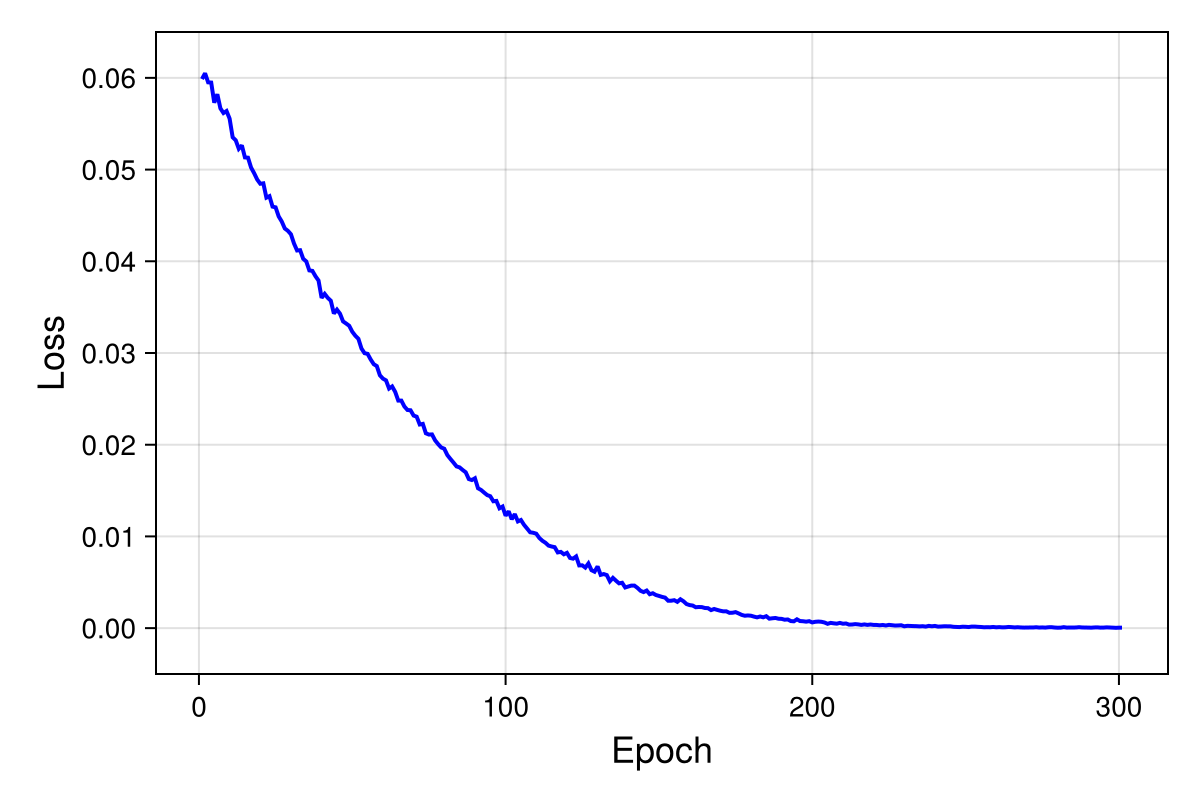

In [12]:
fig3 = Figure(size = (600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss",
    xlabelsize = 18,
    ylabelsize = 18
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2, color = :blue)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

ylims!(ax3, -0.005, 0.065)
display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [13]:
println(β_set_trace[end])

[0.1, 0.13732640709952898, 0.17384043865787974, 0.20919822610702365, 0.2433212990085105, 0.27598626939162363, 0.30720776564526275, 0.33669855472233434, 0.3643756666295601, 0.38976632208303175, 0.4117310163713121, 0.43074372690969265, 0.45008186237968917, 0.4733750106460681, 0.5032264141806669, 0.5404639327281142, 0.5881522801426124, 0.6534737948677594, 0.7539318660933316, 1.0]
